## AutoPark - Number Plate Detection and Recognition
---
42028 - Assignment 3 - By PlateMates (Group 6)

The dataset used can be found here: https://github.com/detectRecog/CCPD

#### Import necessary modules

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report

# import the pre-trained CNN and its related preprocessing method
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Conv2D, Flatten, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model

## Dataset Annotations

Annotations are embedded in the file name.

A sample image name is "025-95_113-154&383_386&473-386&473_177&454_154&383_363&402-0_0_22_27_27_33_16-37-15.jpg". Each name can be split into seven fields. Those fields are explained as follows.

- **Area**: Area ratio of license plate area to the entire picture area.

- **Tilt degree**: Horizontal tilt degree and vertical tilt degree.

- **Bounding box coordinates**: The coordinates of the left-up and the right-bottom vertices.

- **Four vertices locations**: The exact (x, y) coordinates of the four vertices of LP in the whole image. These coordinates start from the right-bottom vertex.

- **License plate number**: Each image in CCPD has only one LP. Each LP number is comprised of a Chinese character, a letter, and five letters or numbers. A valid Chinese license plate consists of seven characters: province (1 character), alphabets (1 character), alphabets+digits (5 characters). "0_0_22_27_27_33_16" is the index of each character. These three arrays are defined as follows. The last character of each array is letter O rather than a digit 0. We use O as a sign of "no character" because there is no O in Chinese license plate characters.
```
provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']
```

- **Brightness**: The brightness of the license plate region.

- **Blurriness**: The Blurriness of the license plate region.

In [2]:
def load_dataset(directory, target_size):
    """Loads and preprocesses images from given directory"""
    files = sorted(os.listdir(directory))

    images = []
    boxes = []
    plate_labels = []

    for filename in files:
        # get bounding box coords and plate number
        f = filename.split("-")
        bounding_box = [int(e) for e in f[2].split("_") for e in e.split("&")] # gives [xmin, ymin, xmax, ymax]
        plate_number = [int(e) for e in f[4].split("_")]

        # extract image data to numpy array
        image_path = os.path.join(directory, filename)
        img = image.load_img(image_path, target_size=target_size)
        img_arr = image.img_to_array(img)
        img_arr = preprocess_input(img_arr) # Xception preprocessing

        # scale bounding box to new ratio and normalise
        x_scale = target_size[0] / 720 # TODO remove hardcoding for original width/height
        y_scale = target_size[0] / 1160
        bounding_box = np.round([
            e * x_scale if (i % 2 == 0) else 
            e * y_scale for i, e in enumerate(bounding_box)]) / target_size[0] # normalise bounding boxes
        
        images.append(img_arr)
        boxes.append(bounding_box)
        plate_labels.append(plate_number)
    
    return np.array(images), np.array(boxes), np.array(plate_labels)

In [3]:
# directory for saving model checkpoints during training
checkpoint_dir = "checkpoints/"

base_dir = "dataset/"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

target_size = (512, 512)

# load data for each set
X_train, y_train_boxes, y_train_labels = load_dataset(train_dir, target_size)
X_val, y_val_boxes, y_val_labels  = load_dataset(val_dir, target_size)
X_test, y_test_boxes, y_test_labels  = load_dataset(test_dir, target_size)

print(X_train.shape, y_train_boxes.shape, y_train_labels.shape)

(700, 512, 512, 3) (700, 4) (700, 7)


### Utility functions

In [4]:
# source: http://ronny.rest/tutorials/module/localization_001/iou/

def get_iou(a, b):
    """ Given two boxes `a` and `b` defined as a list of four numbers:
            [x1,y1,x2,y2]
        where:
            x1,y1 represent the upper left corner
            x2,y2 represent the lower right corner
        It returns the Intersect of Union score for these two boxes.

    Args:
        a:          (list of 4 numbers) [x1,y1,x2,y2]
        b:          (list of 4 numbers) [x1,y1,x2,y2]
        epsilon:    (float) Small value to prevent division by zero

    Returns:
        (float) The Intersect of Union score.
    """
    epsilon = keras.backend.epsilon()
    
    # COORDINATES OF THE INTERSECTION BOX
    x1 = max(a[0], b[0])
    y1 = max(a[1], b[1])
    x2 = min(a[2], b[2])
    y2 = min(a[3], b[3])

    # AREA OF OVERLAP - Area where the boxes intersect
    width = (x2 - x1)
    height = (y2 - y1)
    # handle case where there is NO overlap
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height

    # COMBINED AREA
    area_a = (a[2] - a[0]) * (a[3] - a[1])
    area_b = (b[2] - b[0]) * (b[3] - b[1])
    area_combined = area_a + area_b - area_overlap

    # RATIO OF AREA OF OVERLAP OVER COMBINED AREA
    iou = area_overlap / (area_combined+epsilon)
    
    return iou

def mean_iou(a, b):
    """ Given two arrays `a` and `b` where each row contains a bounding
        box defined as a list of four numbers:
            [x1,y1,x2,y2]
        where:
            x1,y1 represent the upper left corner
            x2,y2 represent the lower right corner
        It returns the mean of the Intersect of Union scores for each corresponding
        pair of boxes.

    Args:
        a:          (numpy array) each row containing [x1,y1,x2,y2] coordinates
        b:          (numpy array) each row containing [x1,y1,x2,y2] coordinates

    Returns:
        (float) The mean of the Intersect of Union scores for each pair of bounding
        boxes.
    """
    epsilon = keras.backend.epsilon()
    
    # COORDINATES OF THE INTERSECTION BOXES
    x1 = keras.backend.max([a[:, 0], b[:, 0]], axis=0)
    y1 = keras.backend.max([a[:, 1], b[:, 1]], axis=0)
    x2 = keras.backend.min([a[:, 2], b[:, 2]], axis=0)
    y2 = keras.backend.min([a[:, 3], b[:, 3]], axis=0)

    # AREAS OF OVERLAP - Area where the boxes intersect
    width = (x2 - x1)
    height = (y2 - y1)

    # handle case where there is NO overlap
    width = keras.backend.maximum(width, 0)
    height = keras.backend.maximum(height, 0)

    area_overlap = width * height

    # COMBINED AREAS
    area_a = (a[:, 2] - a[:, 0]) * (a[:, 3] - a[:, 1])
    area_b = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])
    area_combined = area_a + area_b - area_overlap

    # RATIO OF AREA OF OVERLAP OVER COMBINED AREA
    iou = area_overlap / (area_combined + epsilon)
    
    # Mean IoU 
    iou_mean = keras.backend.mean(iou)
    
    return iou_mean

In [5]:
def get_bbox(boxes, scale=target_size[0]):
    """Returns de-normalised bounding boxes"""
    return boxes * scale

### Sample images from the dataset

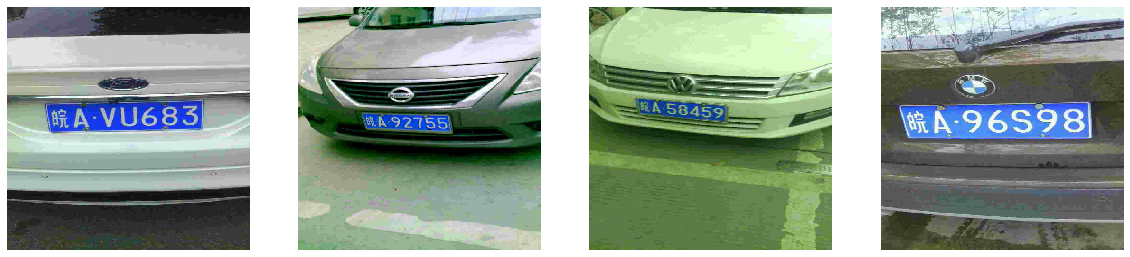

Image indices: [610, 149, 226, 686]


In [6]:
fig, axes = plt.subplots(1, 4, figsize=(20, 10))
plot_indices = []

for ax in axes:
    i = np.random.randint(len(X_train)) # display random images
    plot_indices.append(i)
    img = image.array_to_img(X_train[i])

    ax.imshow(img)
    ax.axis("off")

plt.show()
print("Image indices:", plot_indices)

## Build the model  
Uses Xception with imagenet weights as the base model

In [7]:
keras.backend.clear_session() # clear previous models from memory

input_shape = (512, 512, 3)
base_model = Xception(include_top=False, weights="imagenet", input_shape=input_shape)

In [8]:
# start from block13_sepconv2_activation to begin with 32x32 dimensionality
x = base_model.layers[-13].output

x = Conv2D(1024, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(1024, (1, 1), activation="relu")(x)

x = Conv2D(256, (1, 1), activation="relu", padding="same")(x)
x = Conv2D(512, (3, 3), strides=(2, 2), activation="relu")(x)

x = Conv2D(128, (1, 1), activation="relu", padding="same")(x)
x = Conv2D(256, (3, 3), strides=(2, 2), activation="relu")(x)

x = Conv2D(128, (1, 1), activation="relu", padding="same")(x)
x = Conv2D(256, (3, 3), strides=(2, 2), activation="relu")(x)

x = Conv2D(128, (1, 1), activation="relu", padding="same")(x)
x = Conv2D(256, (3, 3), strides=(2, 2), activation="relu")(x)

# FC layers and 4 neuron output layer for bounding box coordinates
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dense(512, activation="relu")(x)

x = Dense(4, activation=None)(x)

# this is the model to be trained
model = Model(inputs=base_model.input, outputs=x)

# freeze the base_model layers
for layer in base_model.layers[:-13]:
    layer.trainable = False

# compile model
model.compile(optimizer="adam", loss="huber_loss", metrics=[mean_iou])

In [9]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 255, 255, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 255, 255, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 255, 255, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [10]:
# setup callbacks to use during training
chk_path = os.path.join(checkpoint_dir, "model.{epoch:02d}-{val_mean_iou:.4f}.h5")
# chk_path = os.path.join(checkpoint_dir, "model.h5")

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=chk_path,
    monitor="val_mean_iou",
    mode="max",
    save_weights_only=True,
    save_best_only=True)

my_callbacks = [
    checkpoint_callback,
    # keras.callbacks.ReduceLROnPlateau(patience=4),
    # keras.callbacks.EarlyStopping(patience=5)
]

## Train the model

In [11]:
eps = 60
b_size = 32

# train model
history = model.fit(X_train, y_train_boxes, batch_size=b_size, epochs=eps, verbose=2,
                    validation_data=(X_val, y_val_boxes), callbacks=my_callbacks)

Train on 700 samples, validate on 150 samples
Epoch 1/60
700/700 - 23s - loss: 0.7760 - mean_iou: 0.0542 - val_loss: 0.0074 - val_mean_iou: 0.1652
Epoch 2/60
700/700 - 11s - loss: 0.0048 - mean_iou: 0.3141 - val_loss: 0.0071 - val_mean_iou: 0.1321
Epoch 3/60
700/700 - 12s - loss: 0.0036 - mean_iou: 0.3787 - val_loss: 0.0060 - val_mean_iou: 0.2212
Epoch 4/60
700/700 - 12s - loss: 0.0033 - mean_iou: 0.4050 - val_loss: 0.0051 - val_mean_iou: 0.2436
Epoch 5/60
700/700 - 12s - loss: 0.0032 - mean_iou: 0.4040 - val_loss: 0.0047 - val_mean_iou: 0.2495
Epoch 6/60
700/700 - 11s - loss: 0.0032 - mean_iou: 0.3901 - val_loss: 0.0055 - val_mean_iou: 0.1982
Epoch 7/60
700/700 - 11s - loss: 0.0026 - mean_iou: 0.4459 - val_loss: 0.0059 - val_mean_iou: 0.1657
Epoch 8/60
700/700 - 12s - loss: 0.0022 - mean_iou: 0.4667 - val_loss: 0.0032 - val_mean_iou: 0.3216
Epoch 9/60
700/700 - 12s - loss: 0.0015 - mean_iou: 0.5238 - val_loss: 0.0027 - val_mean_iou: 0.3362
Epoch 10/60
700/700 - 12s - loss: 8.9356e-04 

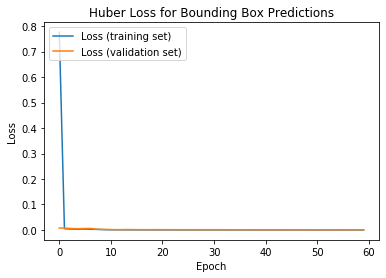

In [12]:
# plot model loss
plt.plot(history.history['loss'], label='Loss (training)')
plt.plot(history.history['val_loss'], label='Loss (validation)')
plt.title('Huber Loss for Bounding Box Predictions')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

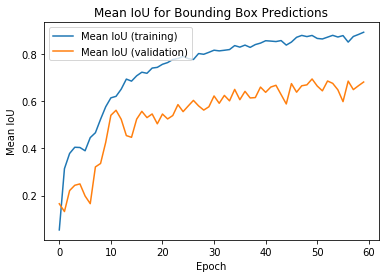

In [13]:
# plot model mean iou
plt.plot(history.history['mean_iou'], label='Mean IoU (training)')
plt.plot(history.history['val_mean_iou'], label='Mean IoU (validation)')
plt.title('Mean IoU for Bounding Box Predictions')
plt.ylabel('Mean IoU')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

In [14]:
# make predictions on bounding box locations
y_preds = model.predict(X_test)

In [15]:
print(model.evaluate(X_test, y_test_boxes))

150/150 [==============================] - 2s 11ms/sample - loss: 4.7615e-04 - mean_iou: 0.6721
[0.00047614541448031864, 0.6720749]


In [16]:
si = 90 # starting index 

print("Ground Truth:")
print(np.array([get_bbox(e) for e in y_test_boxes[si:si + 8]]))
print("Predictions:")
print(np.round([get_bbox(e) for e in y_preds[si:si + 8]]))

Ground Truth:
[[102. 214. 374. 283.]
 [ 92. 218. 371. 286.]
 [126. 204. 388. 277.]
 [102. 197. 363. 271.]
 [117. 177. 338. 265.]
 [154. 198. 437. 268.]
 [ 96. 200. 431. 259.]
 [154. 171. 357. 269.]]
Predictions:
[[109. 215. 367. 276.]
 [141. 237. 347. 284.]
 [132. 212. 370. 267.]
 [104. 198. 352. 262.]
 [109. 175. 325. 249.]
 [161. 193. 424. 255.]
 [107. 191. 412. 249.]
 [151. 180. 357. 256.]]


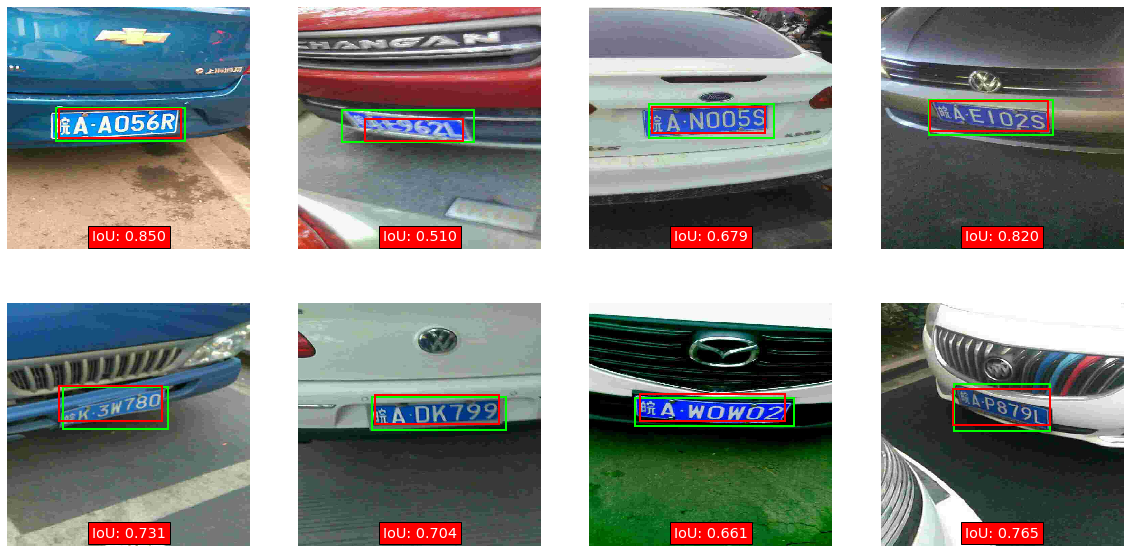

In [17]:
rows = 2
cols = 4
fig, ax = plt.subplots(rows, cols, figsize=(20, 10))

count = 0
for i in range(rows):
    for j in range(cols):
        index = si + count
        y_test_gt = get_bbox(y_test_boxes[index]) # de-normalise
        y_pred = get_bbox(y_preds[index])

        img = image.array_to_img(X_test[index])
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

        # ground truth coordinates
        xmin_gt, ymin_gt, xmax_gt, ymax_gt = y_test_gt
        width_gt = xmax_gt - xmin_gt
        height_gt = ymax_gt - ymin_gt

        # predicted coordinates
        xmin_p, ymin_p, xmax_p, ymax_p = y_pred
        width_p = xmax_p - xmin_p
        height_p = ymax_p - ymin_p

        # draw bounding boxes; lime = ground truth, red = predicted
        rect_gt = patches.Rectangle((xmin_gt, ymin_gt), width_gt, height_gt, linewidth=2, edgecolor="lime", facecolor="none")
        rect_p = patches.Rectangle((xmin_p, ymin_p), width_p, height_p, linewidth=2, edgecolor="red", facecolor="none")
        ax[i, j].add_patch(rect_gt)
        ax[i, j].add_patch(rect_p)

        # draw IoU label
        iou = get_iou(y_test_gt, y_pred)
        label = "IoU: {:.3f}".format(iou)
        ax[i, j].text(256, 500, label, size='x-large', color='white', ha="center", va="bottom", 
                      bbox={'facecolor': "red", 'alpha': 1.0})

        count += 1

plt.show()

In [18]:
# clear model
# keras.backend.clear_session()
# del model